# https://bit.ly/2vRbKer

## Tensorflow 2.0으로 구현하는 주가 예측 모델

Transformer 신경 네트워크를 사용하여 General Electric의 주식 가격을 예측해 봅시다.

![alt text](https://www.allaboutapps.net/images/neuralfundmanager.jpg)


## 1. 데이터 가져오기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# matplotlib에서 한글 출력을 위해서, 한글 서체를 다운로드 받습니다.

!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip"

--2019-05-16 07:31:52--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c01::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip’

NotoSansCJKkr-hinte 100%[===================>] 115.55M  52.2MB/s    in 2.2s    

2019-05-16 07:31:55 (52.2 MB/s) - ‘NotoSansCJKkr-hinted.zip’ saved [121163981/121163981]



In [ ]:
!unzip "NotoSansCJKkr-hinted.zip"

Archive:  NotoSansCJKkr-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  
  inflating: NotoSansCJKkr-Regular.otf  
  inflating: NotoSansCJKkr-Thin.otf  
  inflating: NotoSansMonoCJKkr-Bold.otf  
  inflating: NotoSansMonoCJKkr-Regular.otf  
  inflating: README                  


In [ ]:
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/

In [ ]:
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf'
fontprop = fm.FontProperties(fname=path, size= 15)

# 주가 데이터 다운로드

국내 주식 데이터는 다운로드 받는 경로가 복잡하므로 별도 검색하세요.

https://finance.yahoo.com/quote/GE/history?p=GE&.tsrc=fin-srch 에 방문해서 주식 데이터를 다운로드 받습니다.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving GE.csv to GE.csv
User uploaded file "GE.csv" with length 961450 bytes


In [ ]:
df = pd.read_csv('GE.csv',delimiter=',',usecols=['Date','Open','High','Low','Close', 'Volume'])


In [ ]:
# 날짜로 정렬합니다.
df = df.sort_values('Date')

# 결과를 확인합니다.
df.head()

,Date,Open,High,Low,Close,Volume
0,1962-01-02,0.751202,0.763722,0.743690,0.748698,2156500
1,1962-01-03,0.744942,0.744942,0.738682,0.741186,1477600
2,1962-01-04,0.741186,0.747446,0.726162,0.732422,1837100
3,1962-01-05,0.732422,0.733674,0.701122,0.713642,2725600
4,1962-01-08,0.713642,0.713642,0.691106,0.712390,3095000


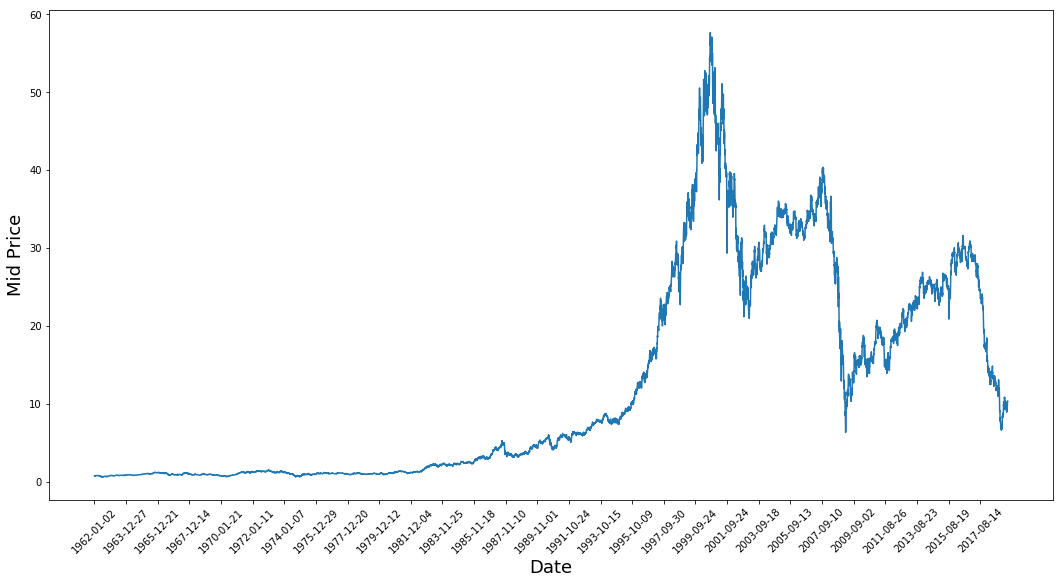

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## 2. 데이터 전처리 

In [ ]:
df['mid'] = (df['Low']+df['High'])/2.0

In [ ]:
SEQ_LEN = 60  # RNN을 위한 한번에 처리할 시계열 데이터의 길이
FUTURE_PERIOD_PREDICT = 1  # 몇 개를 예측할까요?
RATIO_TO_PREDICT = "mid"

In [ ]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [ ]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)

In [ ]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,mid,future,target
0,1962-01-02,0.751202,0.763722,0.743690,0.748698,2156500,0.753706,0.741812,0
1,1962-01-03,0.744942,0.744942,0.738682,0.741186,1477600,0.741812,0.736804,0
2,1962-01-04,0.741186,0.747446,0.726162,0.732422,1837100,0.736804,0.717398,0
3,1962-01-05,0.732422,0.733674,0.701122,0.713642,2725600,0.717398,0.702374,0
4,1962-01-08,0.713642,0.713642,0.691106,0.712390,3095000,0.702374,0.714894,1


In [ ]:
df.tail()

,Date,Open,High,Low,Close,Volume,mid,future,target
14429,2019-04-30,10.23,10.53,9.96,10.17,177185500,10.245,10.255,1
14430,2019-05-01,10.15,10.42,10.09,10.10,99374400,10.255,10.240,0
14431,2019-05-02,10.15,10.40,10.08,10.25,79225800,10.240,10.370,1
14432,2019-05-03,10.30,10.50,10.24,10.50,68815500,10.370,10.350,0
14433,2019-05-06,10.24,10.49,10.21,10.43,43604300,10.350,NaN,0


In [ ]:
times = sorted(df.index.values)  # 데이터 분할을 위해서 인덱스 값을 구합니다.
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # 전체 범위에서 10%
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # 전체 범위에서 20%

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]  
train_df = df[(df.index < last_20pct)]  # 학습은 20%를 제외한 범위를 대상으로 합니다.

In [ ]:
from collections import deque
import numpy as np
import random

In [ ]:
train_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
validation_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
test_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)# don't need this anymore.

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
train_df.head()

,mid,target
0,0.753706,0
1,0.741812,0
2,0.736804,0
3,0.717398,0
4,0.702374,1


In [ ]:
train_data = train_df[RATIO_TO_PREDICT].as_matrix()
valid_data = validation_df[RATIO_TO_PREDICT].as_matrix()
test_data = test_df[RATIO_TO_PREDICT].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


In [ ]:
scaler = MinMaxScaler()

In [ ]:
# 값의 범위를 조정해 줍니다.
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [ ]:
# 학습 데이터에서 불필요한 차원을 제거해줍니다.
train_data = train_data.reshape(-1)

# 검증용 데이터와 테스트 데이터에 대해서도 동일한 과정을 적용합니다.
valid_data = scaler.transform(valid_data).reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [ ]:
# 지수 스무딩을 적용합니다.
EMA = 0.0
gamma = 0.1
for ti in range(11000):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# 전체 데이터 표시를 위해 데이터를 모두 합칩니다.
all_mid_data = np.concatenate([train_data,valid_data, test_data],axis=0)

In [ ]:
X_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    X_train.append(train_data[i-SEQ_LEN:i])
    y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_valid = []
y_valid = []
for i in range(SEQ_LEN, len(valid_data)):
    X_valid.append(valid_data[i-SEQ_LEN:i])
    y_valid.append(valid_data[i+(FUTURE_PERIOD_PREDICT-1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [ ]:
X_test = []
y_test = []
for i in range(SEQ_LEN, len(test_data)):
    X_test.append(test_data[i-SEQ_LEN:i])
    y_test.append(test_data[i+(FUTURE_PERIOD_PREDICT-1)])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
y_train.shape

(11488,)

In [ ]:
print(y_train[:100])

[0.28492208 0.28597166 0.28585246 0.28492684 0.28319363 0.28179741
 0.2802953  0.27959808 0.27847957 0.27649093 0.27339182 0.26929329
 0.26715945 0.26507532 0.26328144 0.26133961 0.25975564 0.25824823
 0.25623689 0.25360836 0.25075169 0.24736236 0.24112048 0.23484812
 0.23173982 0.22976067 0.22814311 0.22611447 0.2235522  0.22116433
 0.21876974 0.21604178 0.21276829 0.21170431 0.21066489 0.20997491
 0.21009042 0.21027622 0.20897044 0.20509476 0.20103382 0.19508765
 0.18670828 0.17793936 0.17430264 0.17037492 0.16520333 0.15964872
 0.15636807 0.15316999 0.15078271 0.14830683 0.14296889 0.13726458
 0.13172154 0.12640547 0.12219383 0.11783053 0.11283974 0.10630213
 0.09722675 0.08750407 0.07965382 0.07217944 0.06872587 0.06758171
 0.06867963 0.07163174 0.0751888  0.07740816 0.07940558 0.08308542
 0.08541528 0.08955797 0.09189524 0.09375328 0.09460719 0.09324805
 0.09292499 0.09361623 0.09464751 0.09557566 0.09469251 0.09537066
 0.09679933 0.09865795 0.10245838 0.10628792 0.10989817 0.1137

In [ ]:
y_valid.shape

(1383,)

In [ ]:
X_train_2 = []
y_train_2 = []
for i in range(SEQ_LEN, len(train_data)):
    X_train_2.append(train_data[i-SEQ_LEN:i])
    y_train_2.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))

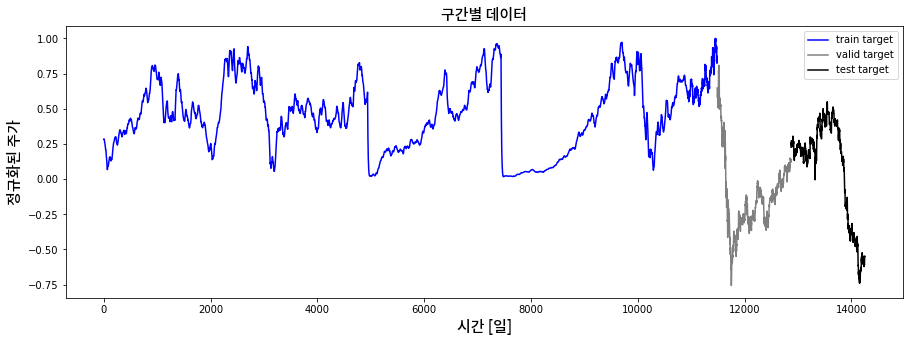

In [ ]:
## 예측값을 보여줍니다.
plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('구간별 데이터', fontproperties=fontprop)
plt.xlabel('시간 [일]', fontproperties=fontprop)
plt.ylabel('정규화된 주가', fontproperties=fontprop)
plt.legend(loc='best');

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
EPOCHS = 10  # 몇 번 학습을 할까요?
BATCH_SIZE = 1024  # 몇 개씩 잘라서 할까요?
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # 모델 이름 작명하기

# 3. 모델 만들기 (The Transformer)

![alt text](https://cdn-images-1.medium.com/max/1600/1*BHzGVskWGS_3jEcYYi6miQ.png)


In [ ]:
!pip install -q tensorflow==2.0.0-alpha0

     |████████████████████████████████| 79.9MB 49.4MB/s 
     |████████████████████████████████| 61kB 28.2MB/s 
     |████████████████████████████████| 419kB 51.6MB/s 
     |████████████████████████████████| 3.0MB 43.5MB/s 


In [ ]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.python.keras.layers import Layer

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [ ]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 1))
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error", 
        #optimizer = Adam(lr = config["lr"], decay = config["lr_d"]), 
        optimizer = "adam")
    
    # Save entire model to a HDF5 file
    #model.save('my_model.h5')
    
    return model

In [ ]:
multi_head = build_model()

In [ ]:
multi_head.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 60, 256)      133120      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 128)      164352      bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 60, 192)      24576       bidirectional_1[0][0]            
______________________________________________________________________________________________

In [ ]:
multi_head.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid), 
                    #callbacks = [checkpoint , lr_reduce]
             )

Train on 11192 samples, validate on 1346 samples
Epoch 1/10
11192/11192 [==============================] - 62s 6ms/sample - loss: 0.1177 - val_loss: 0.0802
Epoch 2/10
11192/11192 [==============================] - 60s 5ms/sample - loss: 0.0168 - val_loss: 0.2586
Epoch 3/10
11192/11192 [==============================] - 56s 5ms/sample - loss: 0.0080 - val_loss: 0.1137
Epoch 4/10
11192/11192 [==============================] - 58s 5ms/sample - loss: 0.0056 - val_loss: 0.1005
Epoch 5/10
11192/11192 [==============================] - 58s 5ms/sample - loss: 0.0047 - val_loss: 0.0932
Epoch 6/10
11192/11192 [==============================] - 57s 5ms/sample - loss: 0.0043 - val_loss: 0.0903
Epoch 7/10
11192/11192 [==============================] - 60s 5ms/sample - loss: 0.0040 - val_loss: 0.0882
Epoch 8/10
11192/11192 [==============================] - 58s 5ms/sample - loss: 0.0037 - val_loss: 0.0878
Epoch 9/10
11192/11192 [==============================] - 58s 5ms/sample - loss: 0.0033 - val_l

In [ ]:
predicted_stock_price_multi_head = multi_head.predict(X_test)
#predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


predicted_stock_price_multi_head.shape

(1346, 1)

In [ ]:
predicted_stock_price_multi_head = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))

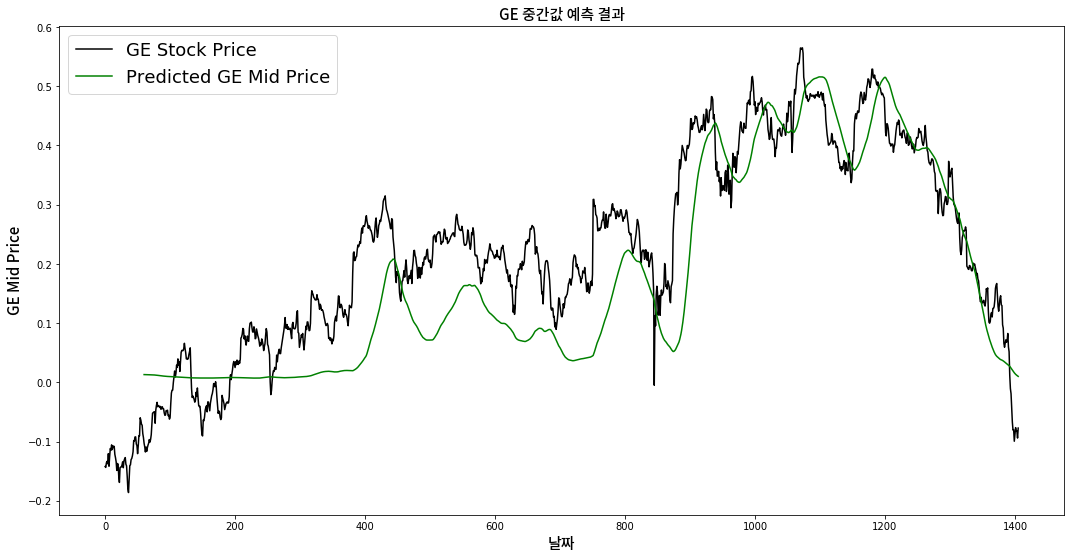

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(test_data, color = 'black', label = 'GE Stock Price')
plt.plot(predicted_stock_price_multi_head, color = 'green', label = 'Predicted GE Mid Price')

plt.title('GE 중간값 예측 결과', fontsize=30, fontproperties=fontprop)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('날짜', fontproperties=fontprop)
plt.ylabel('GE Mid Price', fontproperties=fontprop)
plt.legend(fontsize=18)
plt.show()